In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

c:\Users\borge\Documents\projects\sales_forecasting_inventory\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
clean_path = "../data/retail_store_inventory_clean.csv"
df = pd.read_csv(clean_path, parse_dates=["Date"])

In [3]:
df = df.sort_values(["Store ID", "Product ID", "Date"])


In [4]:
all_forecasts = []

In [5]:
for (store, product), group in df.groupby(["Store ID", "Product ID"]):
    # Prepare Prophet data
    prophet_df = group[["Date", "Units Sold"]].rename(columns={"Date": "ds", "Units Sold": "y"})
    
    if len(prophet_df) < 30:
        # Too few datapoints, skip
        continue
    
    # Train Prophet
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(prophet_df)
    
    # Forecast same length as dataset
    future = model.make_future_dataframe(periods=0, freq="D")  # only in-sample forecast
    forecast = model.predict(future)
    
    # Align with original dates
    merged = group.copy()
    merged["Forecast"] = forecast["yhat"].values
    
    # Store identifiers
    merged["Store ID"] = store
    merged["Product ID"] = product
    merged["Category"] = group["Category"].iloc[0]
    merged["Region"] = group["Region"].iloc[0]
    
    all_forecasts.append(merged)


18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:28 - cmdstanpy - INFO - Chain [1] done processing
18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing
18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing
18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing
18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing
18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1]

In [6]:
forecast_df = pd.concat(all_forecasts, ignore_index=True)

In [7]:
rmse = mean_squared_error(forecast_df["Units Sold"], forecast_df["Forecast"])
mape = mean_absolute_percentage_error(forecast_df["Units Sold"], forecast_df["Forecast"])
print(f"✅ Forecasting complete. RMSE={rmse:.2f}, MAPE={mape:.2%}")

✅ Forecasting complete. RMSE=11398.19, MAPE=290948791914563968.00%


In [8]:
forecast_out = forecast_df[["Date", "Store ID", "Product ID", "Forecast"]]
forecast_out.to_csv("../data/forecast_prophet.csv", index=False)

print("✅ Saved per-store/product forecasts to ../data/forecast_prophet.csv")


✅ Saved per-store/product forecasts to ../data/forecast_prophet.csv


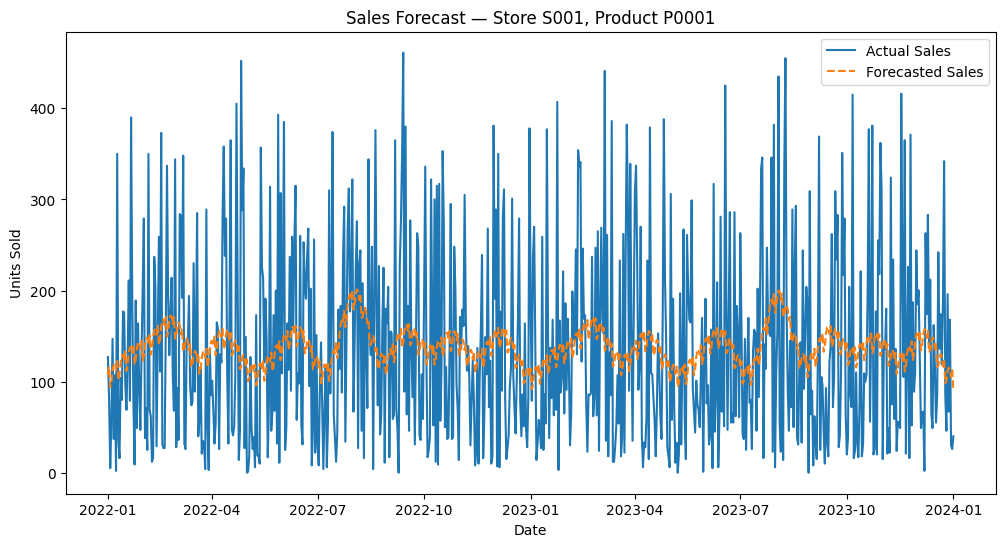

In [9]:
plt.figure(figsize=(12, 6))
sample = forecast_df[(forecast_df["Store ID"] == forecast_df["Store ID"].iloc[0]) & 
                     (forecast_df["Product ID"] == forecast_df["Product ID"].iloc[0])]

plt.plot(sample["Date"], sample["Units Sold"], label="Actual Sales")
plt.plot(sample["Date"], sample["Forecast"], label="Forecasted Sales", linestyle="dashed")

plt.title(f"Sales Forecast — Store {sample['Store ID'].iloc[0]}, Product {sample['Product ID'].iloc[0]}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()